# Training Linear One-Neuron Models

This code is for training 100,000 one-neuron models with varying levels of sparsity and different loss functions. The differences in loss functions is described in the replication paper found <a href="https://github.com/zroe1/toy_models_of_superposition/blob/main/FINDINGS.pdf">here.</a>

In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
import warnings
from torch import nn

In [2]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_device()
print(f"Using {device} device")

Using cuda device


In [3]:
class ManyToyModels(nn.Module):
    def __init__(self, m, n, num_models, include_ReLU):
        '''Create a toy model

        Args:
            m (int): the number of neurons (as described in original paper)
            n (int): the number of features the Toy model can map.
            (The weight matrix is delcared to be m * n)

            include_ReLU (bool): if True, a nonlinearity is added to the network
        '''
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_models, m, n), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(num_models, n, 1), requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        self.inclue_ReLU = include_ReLU

    def forward(self, x):
        hidden = self.weights @ x
        final = torch.transpose(self.weights, -2, -1) @ hidden
        final += self.bias
        if self.inclue_ReLU:
            return self.ReLU(final)
        else:
            return final

class MSE_Multiple_models(nn.Module):
    def __init__(self):
        super(MSE_Multiple_models, self).__init__()

    def forward(self, predictions, targets, importance):
        sub_total = ((predictions - targets)**2).sum(0)
        return torch.sum(sub_total * importance)

In [4]:
sparsity_rows = 1000
importance_rows = 100
probs = torch.repeat_interleave((torch.arange(0, sparsity_rows) / sparsity_rows), 2 * importance_rows)
probs = probs.reshape(sparsity_rows * importance_rows, 1, 2)

def train_1000_models(model, num_models, epochs, total_batchs, batch_size, loss_fn, optimizer, importance):
    model.train()
    loss_total = 0
    for epoch in range(epochs):
        for i in range(total_batchs):
            # calculating sparsity based on model
            rand_tensor = torch.rand(sparsity_rows * importance_rows, 1, 2)
            sparsity_tensor = (probs > rand_tensor).float()

            x = torch.rand(batch_size, num_models, 2, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("(EPOCH:", str(epoch + 1) + ")", "--> loss:", loss_total / (total_batchs * batch_size))
        loss_total = 0

## Training 100,000 Linear Models

In [48]:
model_test = ManyToyModels(1, 2, 100000, False).to(device)

In [49]:
NUM_EPOCHS = 30
BATCHS_PER_EPOCH = 100
BATCH_SIZE = 128
LEARNING_RATE = 1e-2

In [50]:
first_feature_importance = torch.ones(100000, 1)
second_feature_importance = ((torch.arange(100)).repeat(1000, 1) / 10).reshape(100000, 1)
IMPORTANCE = torch.stack((first_feature_importance, second_feature_importance), dim=1).to(device)

In [51]:
optimizer = torch.optim.Adam(model_test.parameters(), lr=LEARNING_RATE)
loss_func = MSE_Multiple_models()
num_models = 100000

train_1000_models(model_test, num_models, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE)

(EPOCH: 1) --> loss: 772262.775
(EPOCH: 2) --> loss: 161320.47046875
(EPOCH: 3) --> loss: 64857.8904296875
(EPOCH: 4) --> loss: 36746.720546875
(EPOCH: 5) --> loss: 25857.49462890625
(EPOCH: 6) --> loss: 20756.72845703125
(EPOCH: 7) --> loss: 18014.30462890625
(EPOCH: 8) --> loss: 16400.17115234375
(EPOCH: 9) --> loss: 15399.145771484375
(EPOCH: 10) --> loss: 14749.794599609375
(EPOCH: 11) --> loss: 14311.428212890625
(EPOCH: 12) --> loss: 14005.14705078125
(EPOCH: 13) --> loss: 13793.63736328125
(EPOCH: 14) --> loss: 13630.862958984375
(EPOCH: 15) --> loss: 13522.014208984376
(EPOCH: 16) --> loss: 13428.155712890624
(EPOCH: 17) --> loss: 13361.977666015626
(EPOCH: 18) --> loss: 13313.62705078125
(EPOCH: 19) --> loss: 13266.664765625
(EPOCH: 20) --> loss: 13235.67900390625
(EPOCH: 21) --> loss: 13209.346044921875
(EPOCH: 22) --> loss: 13188.49134765625
(EPOCH: 23) --> loss: 13177.616171875
(EPOCH: 24) --> loss: 13170.730908203124
(EPOCH: 25) --> loss: 13155.586591796875
(EPOCH: 26) -->

In [64]:
optimizer = torch.optim.Adam(model_test.parameters(), lr=LEARNING_RATE)
loss_func = MSE_Multiple_models()
num_models = 100000

train_1000_models(model_test, num_models, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE)

(EPOCH: 1) --> loss: 13186.568330078126
(EPOCH: 2) --> loss: 13159.0689453125
(EPOCH: 3) --> loss: 13161.2562890625
(EPOCH: 4) --> loss: 13159.626455078125
(EPOCH: 5) --> loss: 13162.96458984375
(EPOCH: 6) --> loss: 13160.20685546875
(EPOCH: 7) --> loss: 13161.143837890624
(EPOCH: 8) --> loss: 13159.79759765625
(EPOCH: 9) --> loss: 13162.392265625
(EPOCH: 10) --> loss: 13163.2719140625
(EPOCH: 11) --> loss: 13161.98828125
(EPOCH: 12) --> loss: 13165.759794921874
(EPOCH: 13) --> loss: 13161.02978515625
(EPOCH: 14) --> loss: 13162.150400390625
(EPOCH: 15) --> loss: 13161.86771484375
(EPOCH: 16) --> loss: 13163.25552734375
(EPOCH: 17) --> loss: 13161.348935546876
(EPOCH: 18) --> loss: 13160.00740234375
(EPOCH: 19) --> loss: 13161.131328125
(EPOCH: 20) --> loss: 13163.4822265625
(EPOCH: 21) --> loss: 13160.15080078125
(EPOCH: 22) --> loss: 13165.15166015625
(EPOCH: 23) --> loss: 13159.871123046874
(EPOCH: 24) --> loss: 13160.26337890625
(EPOCH: 25) --> loss: 13163.285830078124
(EPOCH: 26) 

## Graphing the Results

In [65]:
w = model_test.weights.to('cpu')

In [66]:
w = w.reshape(1000, 100, 1, 2)

In [79]:
model_first_feature = ((torch.abs(w[:,:,:, :1]) > 0.8) & (torch.abs(w[:,:,:, 1:2]) < 0.2)).squeeze()
model_second_feature = ((torch.abs(w[:,:,:, :1]) < 0.2) & (torch.abs(w[:,:,:, 1:2]) > 0.8)).squeeze()

In [80]:
measured_losses = torch.zeros(1000, 100)

In [87]:
measured_losses[model_first_feature] = 1
measured_losses[model_second_feature] = -1

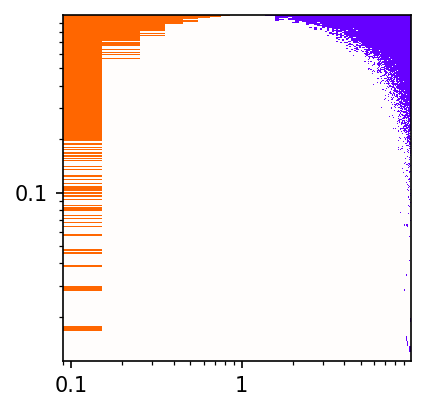

In [88]:
warnings.filterwarnings('ignore')

plt.figure(figsize=(3, 3), dpi=150)

# Set the x-axis to a logarithmic scale
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

colors = [(.4, 0, 1), (1, 1, 1), (1, .4, 0)]  # Purple -> White -> Orange
n_bins = 100
cm = LinearSegmentedColormap.from_list("", colors, N=n_bins)

plt.imshow(measured_losses, cmap=cm, aspect='auto')

# Get current y-ticks
current_yticks = plt.gca().get_yticks()

plt.gca().invert_yaxis()
plt.gca().set_xticklabels(['', '', '0.1', '1', '10', '', ''])
plt.gca().set_yticklabels(['', '', '0.1', '0.1', ''])

plt.show()